<a href="https://colab.research.google.com/github/jnsbrdbr/machine_learning_pojects/blob/master/semi_supervised_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation

#from keras.utils import to_categorical

from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
#load dataset and set it between -1,1 because of tanh in generator 
def load_real_samples(n_classes=10):
    (trainX, trainy), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation. 
    print(X.shape, trainy.shape)
    return [X, trainy]

In [3]:
#100 dataset with its label
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
  X, y = dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples / n_classes) #Number of amples per class. 
  for i in range(n_classes):
         X_with_class = X[y == i] # get all images for this class
         ix = randint(0, len(X_with_class), n_per_class) # choose random images for each class
         [X_list.append(X_with_class[j]) for j in ix] # add to list
         [y_list.append(i) for j in ix]
  return asarray(X_list), asarray(y_list) 

In [4]:
#train unsupervise_descriminator with real images
def generate_real_samples(dataset, n_samples):
    
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training) 
	return [X, labels], y


In [5]:
#generate noise for generator
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

In [6]:
#train unsupervise_descriminator with fake images
def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training) 
	return fake_images, y

In [7]:
#define generator
def define_generator(latent_dim):
	
	in_lat = Input(shape=(latent_dim,))
	#Start with enough dense nodes to be reshaped and ConvTransposed to 28x28x1
	n_nodes = 256 * 7 * 7
	X = Dense(n_nodes)(in_lat)
	X = LeakyReLU(alpha=0.2)(X)
	X = Reshape((7, 7, 256))(X)
	
	X = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(X) #14x14x128
	X = LeakyReLU(alpha=0.2)(X)
	
	X = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(X) #14x14x64
	X = LeakyReLU(alpha=0.2)(X)
	# output
	out_layer = Conv2DTranspose(1, (3,3), strides=(2,2), activation='tanh', 
                             padding='same')(X) #28x28x1
	# define model
	model = Model(in_lat, out_layer)
	return model


In [8]:
#define discriminator
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Flatten()(X)
    X = Dropout(0.4)(X) #Consider adding more dropout layers to minimize overfitting - remember we work with limited labeled data. 
    X = Dense(n_classes)(X)
    
    model = Model(inputs=in_image, outputs=X)
    
    return model

In [9]:
#define supervise discriminator for dtecting probabiliy of object in images
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    #Let us use sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), 
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

In [10]:
#define unsupervise for clasifying fake and real
#and this custom_activation is like sigmoid but better and faster

def custom_activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)
    
    return D_x



def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(custom_activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model


In [11]:
#define gan and combine gnerator and discriminator
def define_gan(gen_model, disc_unsup):
	
	disc_unsup.trainable = False 
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc. gen_model = define_generator(latent_dim) #Generator
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

In [12]:
#save and show model
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):

	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
	
	X = (X + 1) / 2.0 
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
    

	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))


In [13]:
# train the generator and discriminator
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	
    
	X_sup, y_sup = select_supervised_samples(dataset)
	
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	
	n_steps = bat_per_epo * n_epochs
	
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, 
                                                              n_batch, half_batch, 
                                                              bat_per_epo, n_steps))
	
    
	for i in range(n_steps):
		
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)
        
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) 
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
       
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)
        
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)
        
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

#################################
# TRAIN
#################################

latent_dim = 100
disc=define_discriminator() 
disc_sup=define_sup_discriminator(disc) 
disc_unsup=define_unsup_discriminator(disc) 

gen_model = define_generator(latent_dim) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN
dataset = load_real_samples() #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)

# train the model
# NOTE: 1 epoch = 600 steps in this example. 
train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=10, n_batch=100)

 8192/29515 [=======>......................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)
n_epochs=10, n_batch=100, 1/2=50, b/e=600, steps=6000
2/2 [==============================] - 0s 78ms/step
>1, c[2.299,6], d[0.097,2.399], g[0.095]
2/2 [==============================] - 0s 92ms/step
>2, c[2.292,20], d[0.095,2.398], g[0.095]
2/2 [==============================] - 0s 97ms/step
>3, c[2.283,20], d[0.093,2.397], g[0.095]
2/2 [==============================] - 0s 121ms/step
>4, c[2.279,26], d[0.091,2.397], g[0.096]
2/2 [==============================] - 0s 116ms/step
>5, c[2.264,24], d[0.089,2.396], g[0.096]
2/2 [==============================] - 0s 103ms/step
>6, c[2.263,16], d[0.087,2.394], g[0.096]
2/2 [==============================] - 0s 118ms/step
>7, c[2.249,24], d[0.085,2.392], g[0.096]
2/2 [==============================] - 0s 93ms/step
>8, c[2.239,24], d[0.083,2.389], g[0.097]
2/2 [==============================] - 0s 157ms/step
>9, c[2.198,36], d[0.080,2.389], g[0.097]
2/2 [

Discriminator Accuracy: 69.667%
>Saved: generated_plot_0600.png, gen_model_0600.h5, and disc_sup_0600.h5
2/2 [==============================] - 0s 60ms/step
>601, c[0.154,98], d[0.720,0.937], g[0.909]
2/2 [==============================] - 0s 66ms/step
>602, c[0.148,98], d[0.579,1.110], g[0.976]
2/2 [==============================] - 0s 60ms/step
>603, c[0.169,96], d[0.863,0.730], g[0.952]
2/2 [==============================] - 0s 62ms/step
>604, c[0.191,96], d[0.937,0.820], g[1.097]
2/2 [==============================] - 0s 57ms/step
>605, c[0.143,100], d[0.817,0.671], g[0.988]
2/2 [==============================] - 0s 57ms/step
>606, c[0.187,92], d[0.748,0.840], g[1.153]
2/2 [==============================] - 0s 56ms/step
>607, c[0.168,96], d[1.071,0.720], g[0.938]
2/2 [==============================] - 0s 57ms/step
>608, c[0.157,98], d[0.873,0.709], g[0.933]
2/2 [==============================] - 0s 62ms/step
>609, c[0.114,100], d[0.851,0.725], g[0.887]
2/2 [========================

Discriminator Accuracy: 70.368%
>Saved: generated_plot_1200.png, gen_model_1200.h5, and disc_sup_1200.h5
2/2 [==============================] - 0s 61ms/step
>1201, c[0.045,100], d[0.921,0.680], g[1.037]
2/2 [==============================] - 0s 57ms/step
>1202, c[0.095,100], d[0.820,1.204], g[1.034]
2/2 [==============================] - 0s 55ms/step
>1203, c[0.067,100], d[0.808,0.733], g[1.037]
2/2 [==============================] - 0s 57ms/step
>1204, c[0.087,98], d[0.889,1.030], g[1.050]
2/2 [==============================] - 0s 56ms/step
>1205, c[0.086,98], d[0.771,0.780], g[1.066]
2/2 [==============================] - 0s 59ms/step
>1206, c[0.079,100], d[0.792,0.806], g[1.136]
2/2 [==============================] - 0s 58ms/step
>1207, c[0.084,98], d[0.650,0.904], g[1.074]
2/2 [==============================] - 0s 60ms/step
>1208, c[0.061,100], d[0.792,0.918], g[1.172]
2/2 [==============================] - 0s 60ms/step
>1209, c[0.070,100], d[0.617,0.575], g[1.053]
2/2 [===========

Discriminator Accuracy: 70.582%
>Saved: generated_plot_1800.png, gen_model_1800.h5, and disc_sup_1800.h5
2/2 [==============================] - 0s 63ms/step
>1801, c[0.028,100], d[0.973,0.675], g[1.026]
2/2 [==============================] - 0s 62ms/step
>1802, c[0.046,100], d[0.703,0.998], g[0.968]
2/2 [==============================] - 0s 61ms/step
>1803, c[0.044,100], d[0.858,0.855], g[1.040]
2/2 [==============================] - 0s 63ms/step
>1804, c[0.033,100], d[0.831,0.935], g[1.017]
2/2 [==============================] - 0s 62ms/step
>1805, c[0.037,100], d[0.620,0.744], g[1.077]
2/2 [==============================] - 0s 72ms/step
>1806, c[0.024,100], d[0.747,0.847], g[0.998]
2/2 [==============================] - 0s 65ms/step
>1807, c[0.041,100], d[0.882,0.570], g[1.041]
2/2 [==============================] - 0s 68ms/step
>1808, c[0.039,100], d[0.733,0.741], g[0.969]
2/2 [==============================] - 0s 65ms/step
>1809, c[0.040,100], d[0.754,0.855], g[0.999]
2/2 [========

Discriminator Accuracy: 70.725%
>Saved: generated_plot_2400.png, gen_model_2400.h5, and disc_sup_2400.h5
2/2 [==============================] - 0s 68ms/step
>2401, c[0.044,98], d[0.650,0.995], g[1.077]
2/2 [==============================] - 0s 58ms/step
>2402, c[0.032,100], d[1.023,0.683], g[1.069]
2/2 [==============================] - 0s 71ms/step
>2403, c[0.018,100], d[0.855,0.850], g[1.027]
2/2 [==============================] - 0s 68ms/step
>2404, c[0.043,100], d[0.710,0.998], g[1.124]
2/2 [==============================] - 0s 72ms/step
>2405, c[0.027,100], d[0.789,0.822], g[1.033]
2/2 [==============================] - 0s 68ms/step
>2406, c[0.020,100], d[0.783,0.686], g[1.058]
2/2 [==============================] - 0s 66ms/step
>2407, c[0.024,100], d[0.634,0.824], g[1.036]
2/2 [==============================] - 0s 64ms/step
>2408, c[0.019,100], d[0.676,0.683], g[1.104]
2/2 [==============================] - 0s 65ms/step
>2409, c[0.040,100], d[0.872,0.949], g[1.114]
2/2 [=========

Discriminator Accuracy: 71.810%
>Saved: generated_plot_3000.png, gen_model_3000.h5, and disc_sup_3000.h5
2/2 [==============================] - 0s 66ms/step
>3001, c[0.016,100], d[0.818,0.659], g[0.923]
2/2 [==============================] - 0s 65ms/step
>3002, c[0.022,100], d[0.791,1.171], g[0.986]
2/2 [==============================] - 0s 66ms/step
>3003, c[0.019,100], d[0.757,0.882], g[1.147]
2/2 [==============================] - 0s 64ms/step
>3004, c[0.018,100], d[0.778,0.875], g[1.019]
2/2 [==============================] - 0s 69ms/step
>3005, c[0.018,100], d[0.797,0.790], g[1.106]
2/2 [==============================] - 0s 67ms/step
>3006, c[0.035,100], d[0.707,0.875], g[1.113]
2/2 [==============================] - 0s 66ms/step
>3007, c[0.015,100], d[0.789,0.707], g[1.051]
2/2 [==============================] - 0s 62ms/step
>3008, c[0.019,100], d[0.839,0.816], g[0.915]
2/2 [==============================] - 0s 66ms/step
>3009, c[0.020,100], d[0.737,0.954], g[1.026]
2/2 [========

Discriminator Accuracy: 71.377%
>Saved: generated_plot_3600.png, gen_model_3600.h5, and disc_sup_3600.h5
2/2 [==============================] - 0s 64ms/step
>3601, c[0.026,100], d[0.894,1.218], g[1.136]
2/2 [==============================] - 0s 60ms/step
>3602, c[0.012,100], d[0.804,0.949], g[1.185]
2/2 [==============================] - 0s 61ms/step
>3603, c[0.012,100], d[0.936,0.679], g[1.220]
2/2 [==============================] - 0s 62ms/step
>3604, c[0.012,100], d[0.991,0.730], g[1.166]
2/2 [==============================] - 0s 76ms/step
>3605, c[0.033,98], d[0.825,0.844], g[0.888]
2/2 [==============================] - 0s 60ms/step
>3606, c[0.014,100], d[0.795,1.085], g[0.992]
2/2 [==============================] - 0s 69ms/step
>3607, c[0.024,100], d[0.676,0.755], g[1.126]
2/2 [==============================] - 0s 66ms/step
>3608, c[0.013,100], d[1.102,0.936], g[0.938]
2/2 [==============================] - 0s 62ms/step
>3609, c[0.009,100], d[0.799,0.866], g[1.037]
2/2 [=========

Discriminator Accuracy: 70.740%
>Saved: generated_plot_4200.png, gen_model_4200.h5, and disc_sup_4200.h5
2/2 [==============================] - 0s 66ms/step
>4201, c[0.016,100], d[0.968,0.855], g[1.066]
2/2 [==============================] - 0s 61ms/step
>4202, c[0.009,100], d[0.814,0.685], g[1.048]
2/2 [==============================] - 0s 65ms/step
>4203, c[0.020,100], d[0.829,1.076], g[1.075]
2/2 [==============================] - 0s 64ms/step
>4204, c[0.020,100], d[0.910,1.008], g[1.033]
2/2 [==============================] - 0s 59ms/step
>4205, c[0.093,96], d[0.808,0.990], g[0.917]
2/2 [==============================] - 0s 62ms/step
>4206, c[0.019,100], d[0.700,1.095], g[0.983]
2/2 [==============================] - 0s 60ms/step
>4207, c[0.011,100], d[0.870,1.027], g[0.900]
2/2 [==============================] - 0s 59ms/step
>4208, c[0.018,100], d[0.753,1.224], g[1.018]
2/2 [==============================] - 0s 60ms/step
>4209, c[0.008,100], d[0.805,1.027], g[0.899]
2/2 [=========

Discriminator Accuracy: 72.113%
>Saved: generated_plot_4800.png, gen_model_4800.h5, and disc_sup_4800.h5
2/2 [==============================] - 0s 68ms/step
>4801, c[0.010,100], d[0.718,0.733], g[1.169]
2/2 [==============================] - 0s 67ms/step
>4802, c[0.006,100], d[1.007,0.604], g[1.048]
2/2 [==============================] - 0s 58ms/step
>4803, c[0.014,100], d[0.780,0.764], g[0.986]
2/2 [==============================] - 0s 63ms/step
>4804, c[0.009,100], d[0.756,1.048], g[1.077]
2/2 [==============================] - 0s 59ms/step
>4805, c[0.007,100], d[0.990,0.794], g[1.042]
2/2 [==============================] - 0s 62ms/step
>4806, c[0.005,100], d[0.790,0.688], g[0.920]
2/2 [==============================] - 0s 59ms/step
>4807, c[0.011,100], d[0.545,0.935], g[0.915]
2/2 [==============================] - 0s 61ms/step
>4808, c[0.014,100], d[0.908,0.782], g[1.040]
2/2 [==============================] - 0s 60ms/step
>4809, c[0.009,100], d[0.876,1.059], g[0.881]
2/2 [========

Discriminator Accuracy: 72.823%
>Saved: generated_plot_5400.png, gen_model_5400.h5, and disc_sup_5400.h5
2/2 [==============================] - 0s 61ms/step
>5401, c[0.017,100], d[0.715,0.609], g[1.009]
2/2 [==============================] - 0s 61ms/step
>5402, c[0.008,100], d[0.823,0.837], g[1.084]
2/2 [==============================] - 0s 67ms/step
>5403, c[0.008,100], d[0.711,0.858], g[1.001]
2/2 [==============================] - 0s 63ms/step
>5404, c[0.007,100], d[0.696,1.066], g[0.910]
2/2 [==============================] - 0s 62ms/step
>5405, c[0.008,100], d[0.793,0.837], g[1.070]
2/2 [==============================] - 0s 66ms/step
>5406, c[0.004,100], d[0.915,0.964], g[0.943]
2/2 [==============================] - 0s 66ms/step
>5407, c[0.007,100], d[0.729,0.941], g[1.190]
2/2 [==============================] - 0s 60ms/step
>5408, c[0.021,100], d[0.876,0.849], g[0.961]
2/2 [==============================] - 0s 62ms/step
>5409, c[0.013,100], d[0.778,0.901], g[1.087]
2/2 [========

Discriminator Accuracy: 72.810%
>Saved: generated_plot_6000.png, gen_model_6000.h5, and disc_sup_6000.h5


Test Accuracy: 72.850%
313/313 [==============================] - 3s 8ms/step


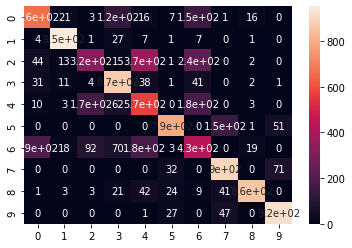

In [14]:
#EVALUATE THE SUPERVISED DISCRIMINATOR ON TEST DATA
# model as a classifier. 
##################################################################
from keras.models import load_model
# load the model
disc_sup_trained_model = load_model('disc_sup_6000.h5')

# load the dataset
(_, _), (testX, testy) = load_data()

# expand to 3d, e.g. add channels
testX = expand_dims(testX, axis=-1)

# convert from ints to floats
testX = testX.astype('float32')

# scale from [0,255] to [-1,1]
testX = (testX - 127.5) / 127.5

# evaluate the model
_, test_acc = disc_sup_trained_model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

# Predicting the Test set results
y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(testy, prediction_test)
sns.heatmap(cm, annot=True)



1/1 [==============================] - 0s 172ms/step


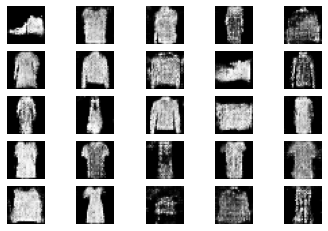

In [15]:
# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray')
	plt.show()

# load model
gen_trained_model = load_model('gen_model_6000.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = gen_trained_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)